<a href="https://colab.research.google.com/github/frankfurtmacmoses/cnn_bagging/blob/main/bagging_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print("Memory growth must be set before initializing GPUs")
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from sklearn.metrics import confusion_matrix
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, labs, theme_minimal,facet_wrap, geom_line,theme
from sklearn.metrics import accuracy_score
import os
print(tf.__version__)

2024-11-16 14:47:37.453393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 14:47:37.462228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 14:47:37.471395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 14:47:37.474297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 14:47:37.482003: I tensorflow/core/platform/cpu_feature_guar

GPU memory growth enabled
2.17.0


In [3]:
cifar100 = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

/tmp/ipykernel_231290/4225888012.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


[[Text(0, 0, 'beaver'),
  Text(1, 0, 'dolphin'),
  Text(2, 0, 'otter'),
  Text(3, 0, 'seal'),
  Text(4, 0, 'whale'),
  Text(5, 0, 'aquarium fish'),
  Text(6, 0, 'flatfish'),
  Text(7, 0, 'ray'),
  Text(8, 0, 'shark'),
  Text(9, 0, 'trout'),
  Text(10, 0, 'orchids'),
  Text(11, 0, 'poppies'),
  Text(12, 0, 'roses'),
  Text(13, 0, 'sunflowers'),
  Text(14, 0, 'tulips'),
  Text(15, 0, 'bottles'),
  Text(16, 0, 'bowls'),
  Text(17, 0, 'cans'),
  Text(18, 0, 'cups'),
  Text(19, 0, 'plates'),
  Text(20, 0, 'apples'),
  Text(21, 0, 'mushrooms'),
  Text(22, 0, 'oranges'),
  Text(23, 0, 'pears'),
  Text(24, 0, 'sweet peppers'),
  Text(25, 0, 'clock'),
  Text(26, 0, 'computer keyboard'),
  Text(27, 0, 'lamp'),
  Text(28, 0, 'telephone'),
  Text(29, 0, 'television'),
  Text(30, 0, 'bed'),
  Text(31, 0, 'chair'),
  Text(32, 0, 'couch'),
  Text(33, 0, 'table'),
  Text(34, 0, 'wardrobe'),
  Text(35, 0, 'bee'),
  Text(36, 0, 'beetle'),
  Text(37, 0, 'butterfly'),
  Text(38, 0, 'caterpillar'),
  Text(

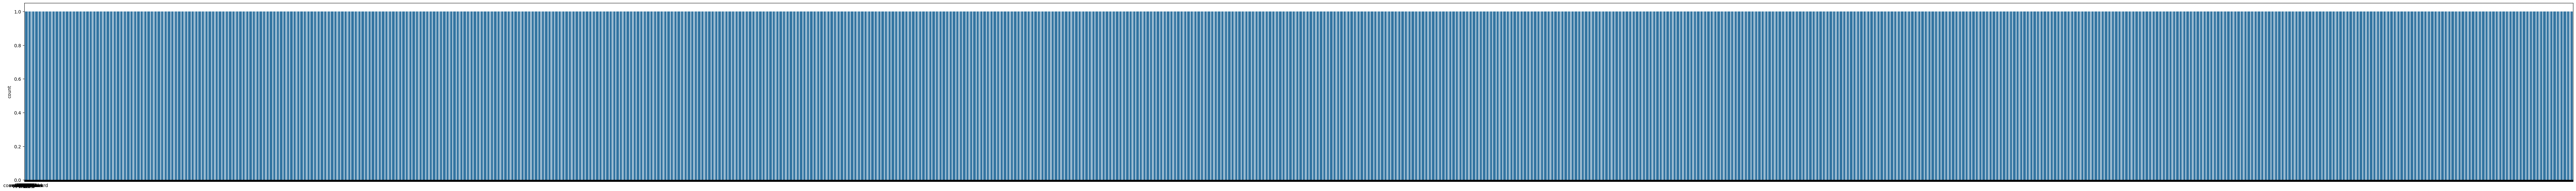

In [5]:
classes = [
    'beaver', 'dolphin', 'otter', 'seal', 'whale',          # Aquatic mammals
    'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',   # Fish
    'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',  # Flowers
    'bottles', 'bowls', 'cans', 'cups', 'plates',           # Food containers
    'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',  # Fruit and vegetables
    'clock', 'computer keyboard', 'lamp', 'telephone', 'television',  # Household electrical devices
    'bed', 'chair', 'couch', 'table', 'wardrobe',           # Household furniture
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',  # Insects
    'bear', 'leopard', 'lion', 'tiger', 'wolf',             # Large carnivores
    'bridge', 'castle', 'house', 'road', 'skyscraper',      # Large man-made outdoor things
    'cloud', 'forest', 'mountain', 'plain', 'sea',          # Large natural outdoor scenes
    'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',  # Large omnivores and herbivores
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',       # Medium-sized mammals
    'crab', 'lobster', 'snail', 'spider', 'worm',           # Non-insect invertebrates
    'baby', 'boy', 'girl', 'man', 'woman',                  # People
    'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',   # Reptiles
    'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',      # Small mammals
    'maple', 'oak', 'palm', 'pine', 'willow',               # Trees
    'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',  # Vehicles 1
    'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor'  # Vehicles 2
]


plt.figure(figsize=(100,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

In [6]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

In [7]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=100)
y_test = tf.one_hot(y_test.astype(np.int32), depth=100)

2024-11-16 14:49:21.865714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22038 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


# Define CNN Model Architecture


In [8]:
def create_cnn_model(num_classes):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])
    return model


# Implement the model

In [9]:

# Parameters

batch_size = 32
num_classes = 100
epochs = 10

num_samples = 5       # Number of subsets
subset_fraction = 0.25  # Fraction of population in each subset
subset_size = int(len(x_train) * subset_fraction)

num_models = 5
models = []

# Convert x_train and y_train to NumPy arrays if they are TensorFlow tensors
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

for _ in range(num_models):
    model = create_cnn_model(num_classes)
    
    # Generate bootstrap samples
    indices = np.random.choice(range(len(x_train_np)), size=subset_size, replace=True)
    x_train_bootstrap = x_train_np[indices]
    y_train_bootstrap = y_train_np[indices]
    
    # Train on the full dataset for initialization
    history = model.fit(x_train_np, y_train_np, batch_size=batch_size, validation_data=(x_test, y_test),
                        epochs=epochs)

    # Train on the bootstrap dataset
    model.fit(x_train_bootstrap, y_train_bootstrap, epochs=epochs, batch_size=batch_size, verbose=0)
    models.append(model)


/home/frankfurt/miniconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
/home/frankfurt/miniconda3/envs/keras_env/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.


Epoch 1/10


I0000 00:00:1731790173.338706  231465 service.cc:146] XLA service 0x7611f40041a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731790173.338728  231465 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-16 14:49:33.361618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 14:49:33.449545: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 170/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - acc: 0.0087 - loss: 4.6059

I0000 00:00:1731790174.962099  231465 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1518/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - acc: 0.0102 - loss: 4.6048

2024-11-16 14:49:36.561635: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1618', 12 bytes spill stores, 12 bytes spill loads



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.0102 - loss: 4.6047 - val_acc: 0.0187 - val_loss: 4.5999
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - acc: 0.0174 - loss: 4.5850 - val_acc: 0.0246 - val_loss: 4.4770
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - acc: 0.0240 - loss: 4.4507 - val_acc: 0.0346 - val_loss: 4.3589
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - acc: 0.0305 - loss: 4.3618 - val_acc: 0.0406 - val_loss: 4.2867
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step - acc: 0.0364 - loss: 4.3122 - val_acc: 0.0470 - val_loss: 4.2433
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - acc: 0.0407 - loss: 4.2742 - val_acc: 0.0501 - val_loss: 4.2141
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - acc: 0.0456 - loss: 4.2319 - val_acc: 0.0628 - val_loss: 4.1687
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - acc: 0.0505 - loss: 4.1982 - val_acc: 0.0683 - val_loss: 4.1320
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━

# Generate Prediction with bagging approach





In [30]:
def ensemble_predictions(models, x_test):
    # Collect predictions from each model
    num_classes = 100  # CIFAR-100 has 100 classes
    predictions = np.zeros((x_test.shape[0], num_classes))

    for model in models:
        predictions += model.predict(x_test)

    # Average predictions
    predictions /= len(models)
    return np.argmax(predictions, axis=1)

# Get ensemble predictions
y_pred = ensemble_predictions(models, x_test)

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f'Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Ensemble Accuracy: 10.84%


# Generate loss and accuracy curve

In [12]:
history = []  # To store loss and accuracy for each model

# Train multiple models in the ensemble
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    hist = model.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        epochs=10,  # Number of epochs
        batch_size=64,
        verbose=1,
    )
    # Append training history for plotting
    history.append(hist.history)


Training model 1
Epoch 1/10


2024-11-16 15:08:25.509882: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1865', 156 bytes spill stores, 156 bytes spill loads

2024-11-16 15:08:25.544108: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1865', 152 bytes spill stores, 152 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.0817 - loss: 4.0221 - val_acc: 0.0989 - val_loss: 3.9676
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.0868 - loss: 3.9948 - val_acc: 0.1053 - val_loss: 3.9398
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.0889 - loss: 3.9780 - val_acc: 0.1113 - val_loss: 3.9172
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.0931 - loss: 3.9589 - val_acc: 0.1145 - val_loss: 3.8982
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.0998 - loss: 3.9349 - val_acc: 0.1187 - val_loss: 3.8675
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.1016 - loss: 3.9192 - val_acc: 0.1269 - val_loss: 3.8410
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.1045 - loss: 3.9001 - val_acc: 0.1264 - val_loss: 3.8342
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.1088 - loss: 3.8747 - val_acc: 0.1302 - val_loss: 3.8003
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.1139 -

In [13]:
# Initialize an empty DataFrame to hold the results of all models
history_df = pd.DataFrame()

# Loop through the history list (one for each model)
for i, single_history in enumerate(history):
    # Convert the history dictionary of the current model into a DataFrame
    temp_df = pd.DataFrame(single_history)  # Directly use the dictionary
    temp_df["Epoch"] = temp_df.index + 1  # Add Epoch column
    temp_df["Model"] = f"Model_{i+1}"  # Add model identifier

    # Append the data from this model to the combined DataFrame
    history_df = pd.concat([history_df, temp_df], ignore_index=True)
print(history_df.columns)


#Melt the DataFrame for visualization
melted_df = pd.melt(
    history_df,
    id_vars=["Epoch", "Model"],
    value_vars=["loss", "val_loss", "acc", "val_acc"],  # Adjust based on available metrics
    var_name="Metric",
    value_name="Value",
)

# Display the melted DataFrame
print(melted_df.head())



Index(['acc', 'loss', 'val_acc', 'val_loss', 'Epoch', 'Model'], dtype='object')
   Epoch    Model Metric     Value
0      1  Model_1   loss  4.017041
1      2  Model_1   loss  3.996019
2      3  Model_1   loss  3.973741
3      4  Model_1   loss  3.953568
4      5  Model_1   loss  3.931109


# Plot the curve


/tmp/ipykernel_202966/1263626140.py:13: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


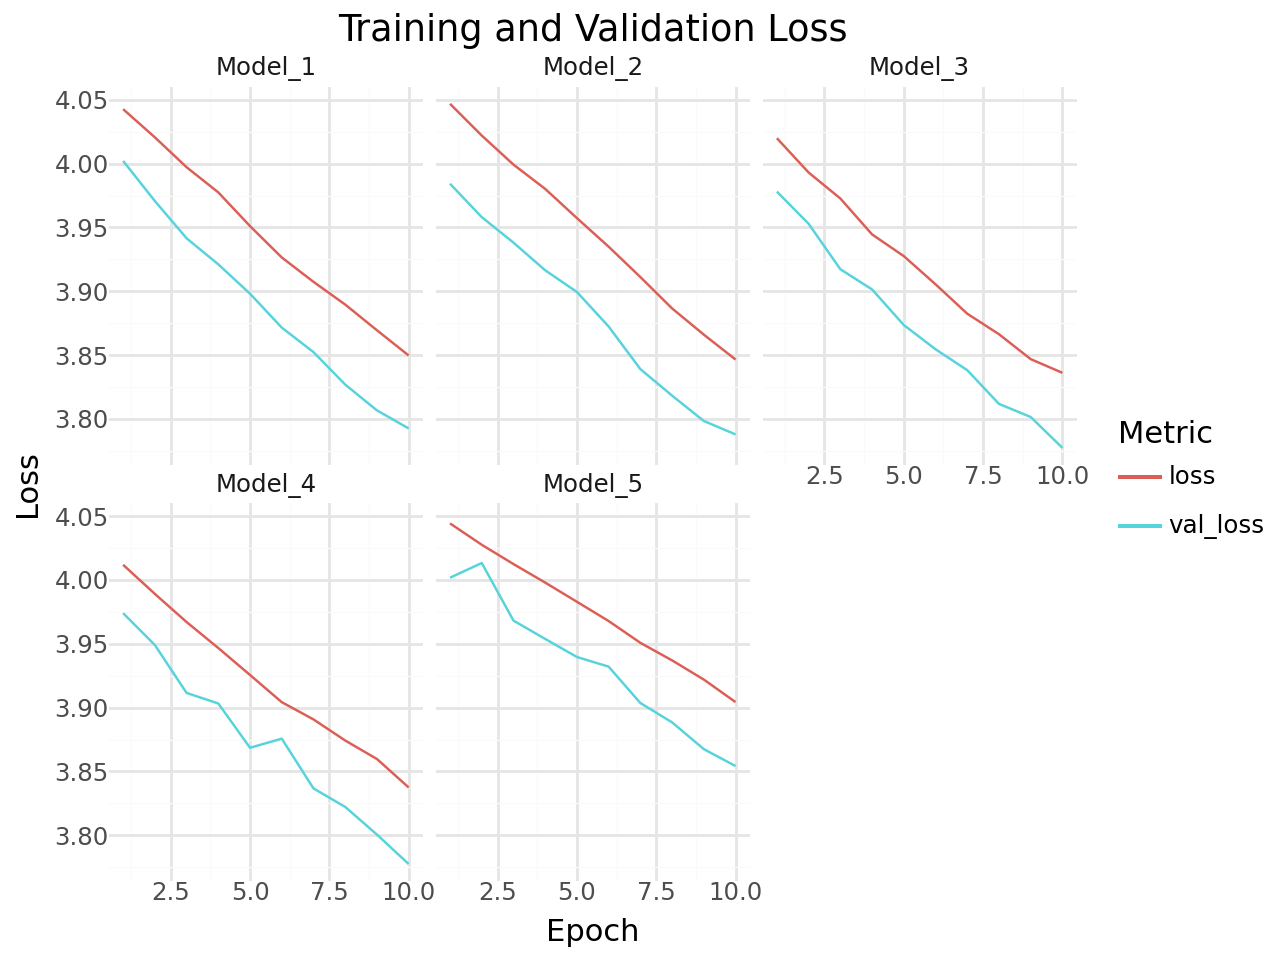

In [44]:


loss_plot = (
    ggplot(melted_df[melted_df["Metric"].isin(["loss", "val_loss"])], aes(x="Epoch", y="Value", color="Metric"))
    + geom_line()
    + facet_wrap("~Model")
    + labs(
        title="Training and Validation Loss",
        x="Epoch",
        y="Loss",
        color="Metric",
    )
    + theme_minimal()
)
print(loss_plot)


/tmp/ipykernel_202966/515922123.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


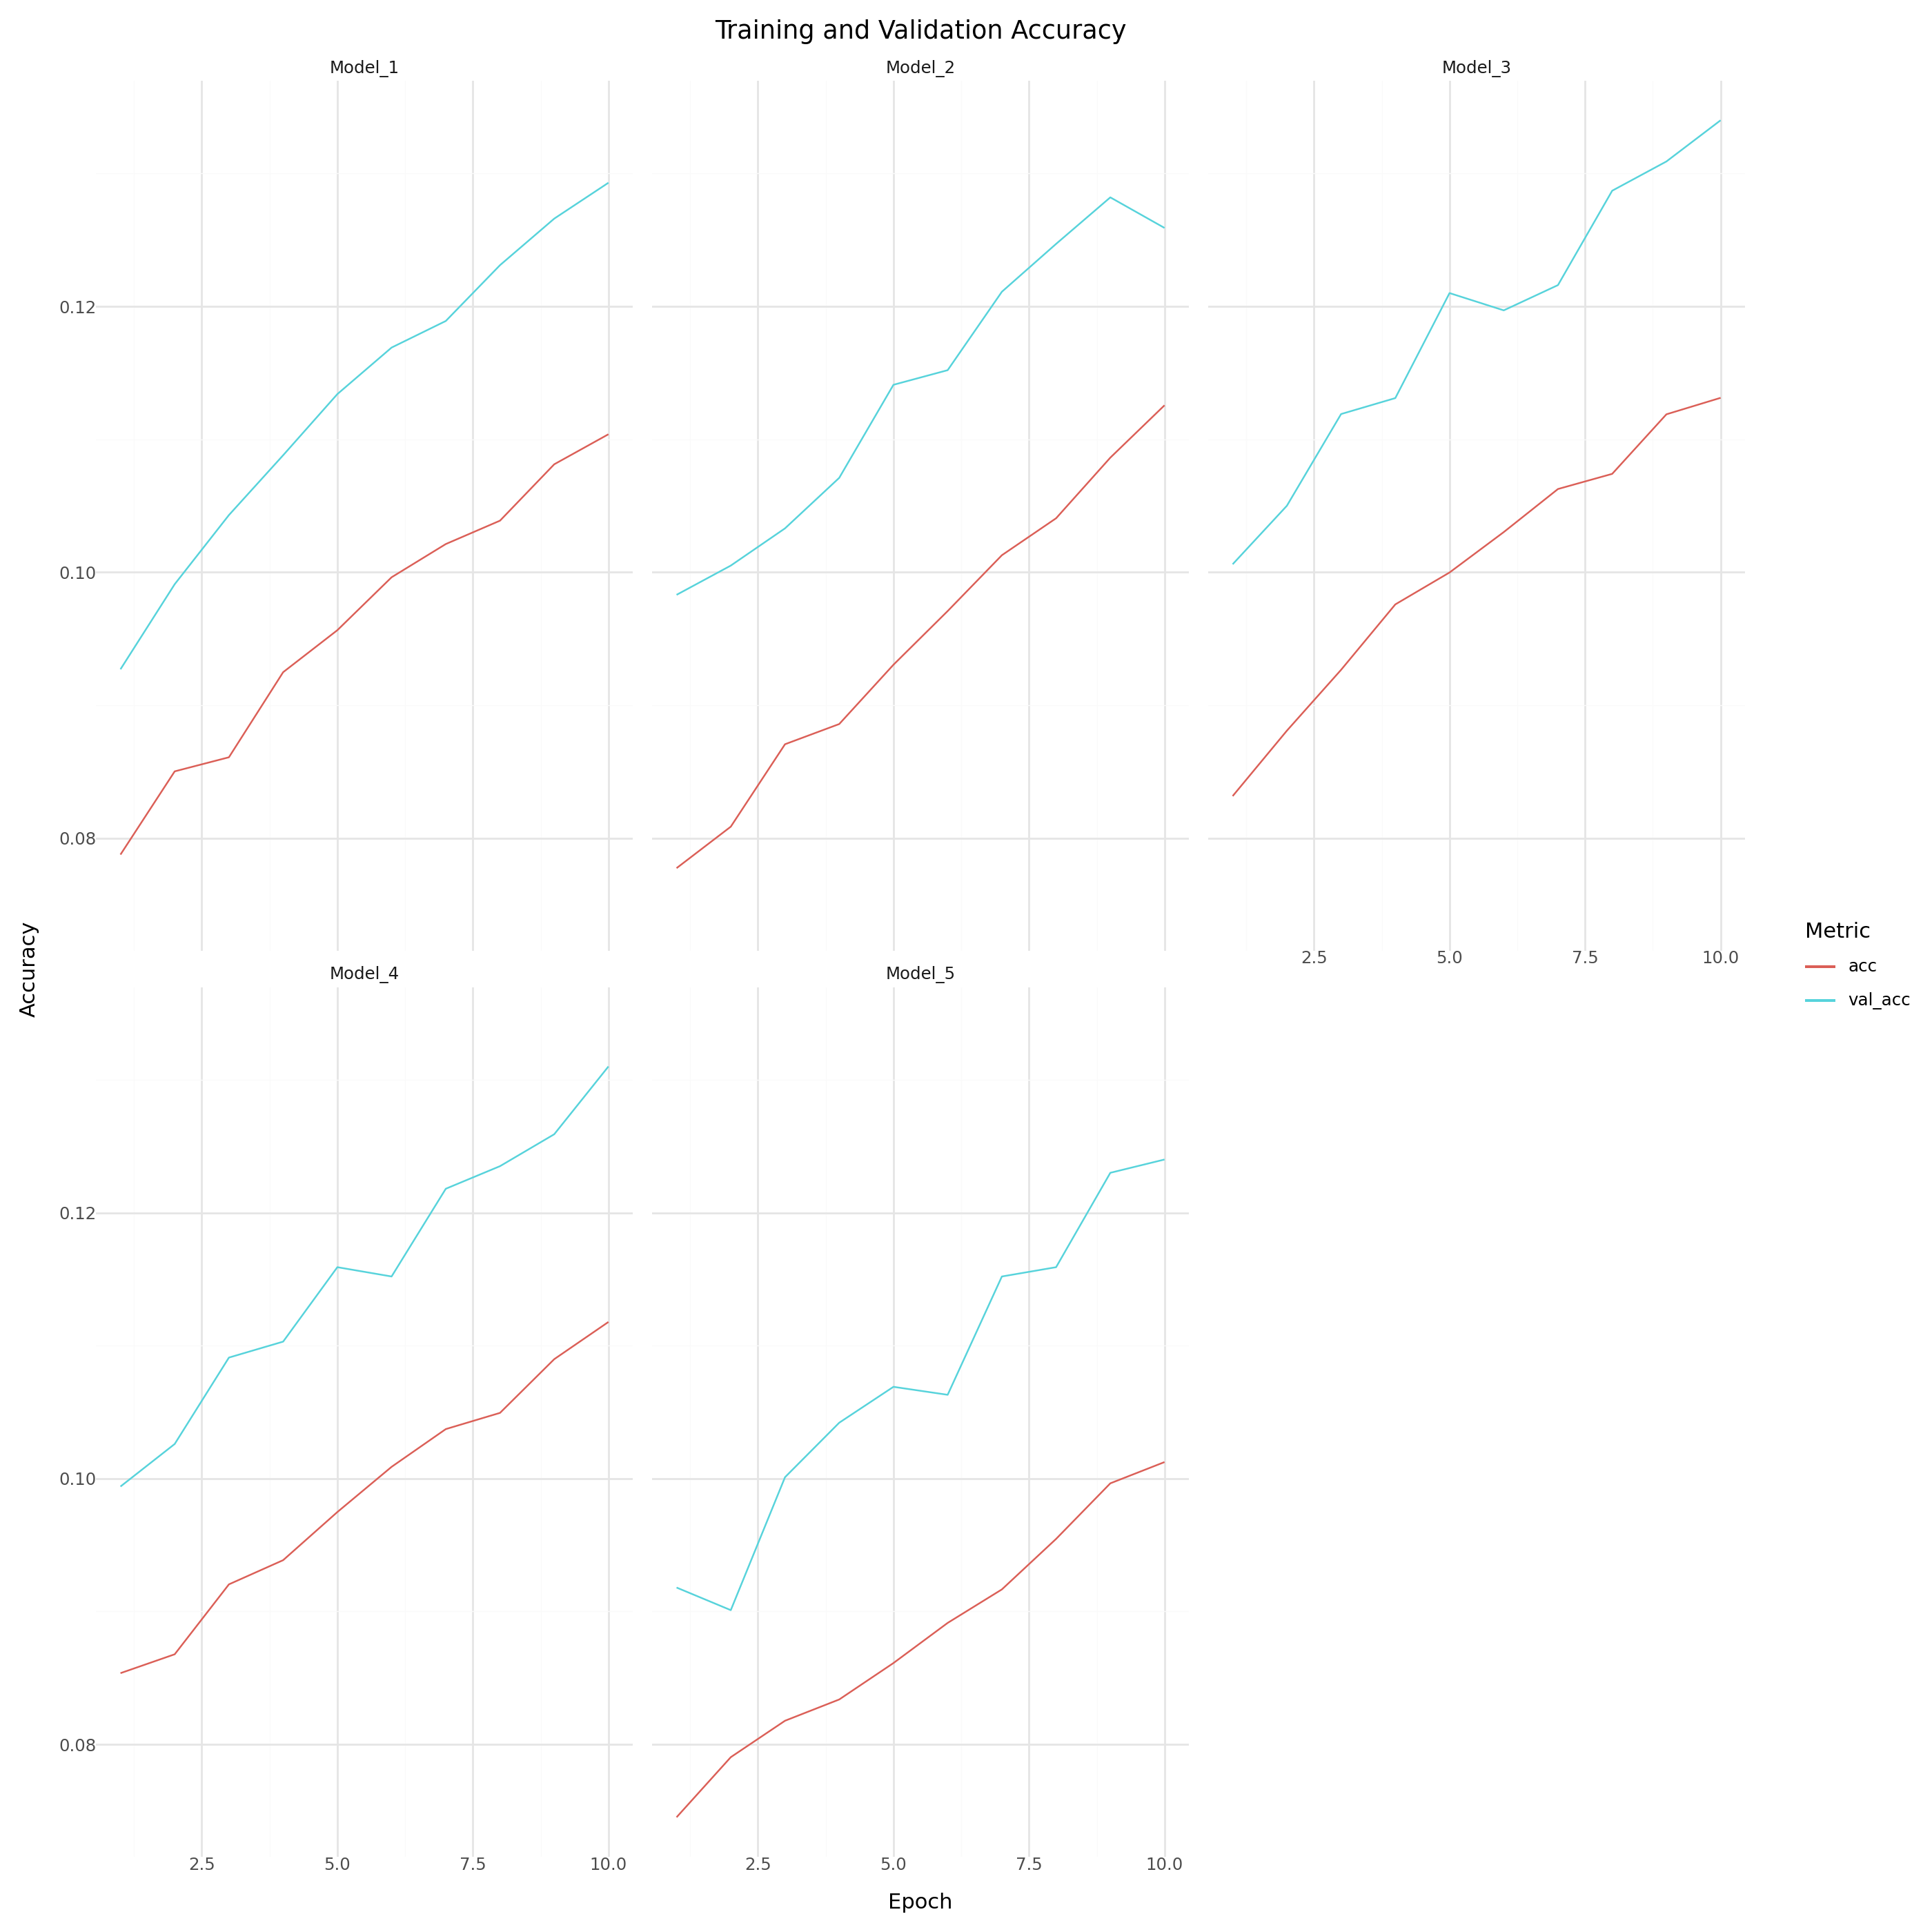

In [59]:
accuracy_plot = (
    ggplot(melted_df[melted_df["Metric"].isin(["acc", "val_acc"])], aes(x="Epoch", y="Value", color="Metric"))
    + geom_line()
    + facet_wrap("~Model")
    + labs(
        title="Training and Validation Accuracy",
        x="Epoch",
        y="Accuracy",
        color="Metric",
    )
    + theme_minimal()
    + theme(figure_size=(14,14))
)
print(accuracy_plot)


# Plot confusion matrix

In [1]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"Class {i}" for i in range(cm.shape[0])],
    columns=[f"Class {i}" for i in range(cm.shape[1])],
)
cm_melted = cm_df.reset_index().melt(id_vars="index")
cm_melted.columns = ["True Class", "Predicted Class", "Count"]

confusion_matrix_plot = (
    ggplot(cm_melted, aes(x="Predicted Class", y="True Class", fill="Count"))
    + geom_tile(color="white")  # Create the heatmap tiles
    + geom_text(aes(label="Count"), size=6, color="black")  # Add text annotations
    + scale_fill_gradient(low="white", high="blue")  # Set color gradient
    + labs(
        title="Confusion Matrix",
        x="Predicted Class",
        y="True Class",
        fill="Count",
    )
    + theme_minimal()
    + theme(
        figure_size=(20, 20)  # Set the figure size to 16 by 10
    )
)

# To display the plot
print(confusion_matrix_plot)


NameError: name 'confusion_matrix' is not defined